## Дерево решений

Задание
1. Построить геометрическую интерпретацию критерия Джини()
2. Применить дерево решений из sklearn для задачи Titanic на kaggle (заполнив пропуски).  
Применить кросс-валидацию для подбора параметров и выбрать лучшие(например с помощью **GridSearchCV** из sklearn).  
Написать отчет о результатах.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv', sep=',')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
test = pd.read_csv('data/test.csv', sep=',')
test_targets = pd.read_csv('data/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [4]:
print(f'train shape - {train.shape}')
print(f'test shape - {test.shape}')

train shape - (891, 12)
test shape - (418, 12)


## Бейзлайн Титаника 

In [5]:
features = ['Pclass', 'Age', 'SibSp',
       'Parch', 'Fare']

pipeline = Pipeline(steps = [('imputer', SimpleImputer()),('scaler',StandardScaler()),('tree',DecisionTreeClassifier())])
grid = {
    'tree__criterion' : ['gini', 'entropy'],
    'tree__max_depth' : [2,5],  
}
baseline = GridSearchCV(pipeline, grid, cv = 3, iid=True)     
baseline.fit(np.array(train.loc[:,features]), np.array(train.Survived))
baseline.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],


In [6]:
baseline.best_score_

0.7115600448933782

In [7]:
accuracy_score(y_pred = baseline.predict(np.array(test[features])), y_true = test.Survived)

0.6770334928229665

## 1. Геометрическая интерпретация критерия Джини 

**Задание** Построить график кривой Лоренца (https://habr.com/ru/company/ods/blog/350440/ - абзац с машиным обучением) 
            для дерева решений с разделением по критерию Джини, используя бейзлайн.

**Пример**

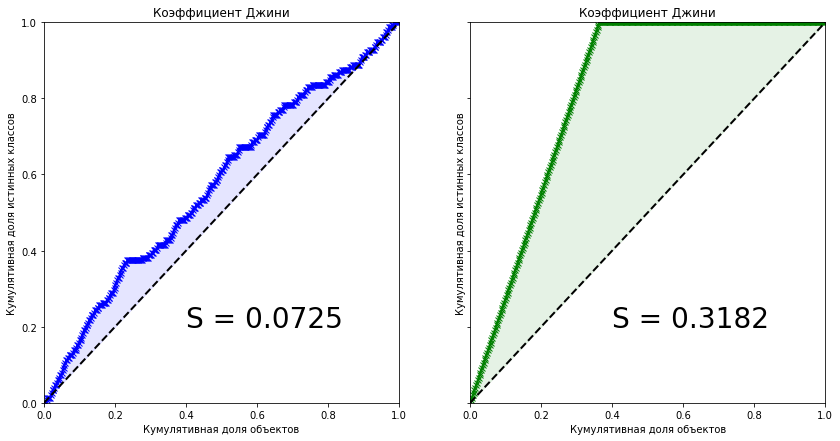

''

In [8]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

baseline_y = pd.DataFrame({'predict': baseline.predict_proba(np.array(test[features]))[:, 1], 'actual': test.Survived})

actual = baseline_y['actual']
predict = baseline_y['predict']

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=len(x_values))[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=len(x_values))[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

''

## 2. Контест Титаник

Побейте безлайн с помощью дерева решений(почерпнуть идеи можно из  
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem,  
но модель в этом задание ограничивается деревом решений), выполните следующие пункты.  
Выберите наиболее сильную модель. Напишите отчет о результатах.


- Придумайте, как нужно использовать дополнительные признаки.
- Примените One-hot-encoding для категориальных признаков.
- Заполнить пропуски
- Применить кроссвалидацию
- отобрать параметры, например с помощью, GridSearchCV

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

features = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
    'Sex', 
    'Embarked', 'Cabin',
]

train = pd.read_csv('data/train.csv', sep=',')

train.loc[train['Age'].isna(), 'Age'] = np.random.normal(
    loc=train['Age'].mean(), 
    scale=train['Age'].std(), 
    size=train['Age'].isna().value_counts().loc[True]
)

test = pd.read_csv('data/test.csv', sep=',')
test_targets = pd.read_csv('data/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)

categorial_features = ['Cabin', 'Embarked', 'Sex']
categorial_features_indices = [i for i, col in enumerate(features) if col in categorial_features]
not_categorial_features_indices = [i for i, col in enumerate(features) if col not in categorial_features]
imputer = ColumnTransformer([
    ('si_mean', SimpleImputer(), not_categorial_features_indices),
    ('si_most_frequent', SimpleImputer(strategy='most_frequent'), categorial_features_indices),
])
    
pipeline = Pipeline(steps = [
    ('imputer', imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('scaler',StandardScaler()),
    ('tree', DecisionTreeClassifier())
])
better = GridSearchCV(pipeline, grid, cv=3, iid=True)     
better.fit(np.array(train.loc[:,features]), np.array(train.Survived))

better.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('si_mean',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0),
                                                  [0, 1, 2, 3, 4]),
                                                 ('si_most_frequent',
                                                  SimpleImputer(add_indicator=False,


In [10]:
better.best_score_

0.8080808080808081

In [11]:
accuracy_score(y_pred = better.predict(np.array(test[features])), y_true = test.Survived)

0.8923444976076556

## 3. Кривая Лоренца

Найдите лучшую модель с использованием Джини и постройте для нее кривую Лоренца,  
сравните с кривой для бейзлайновой модели

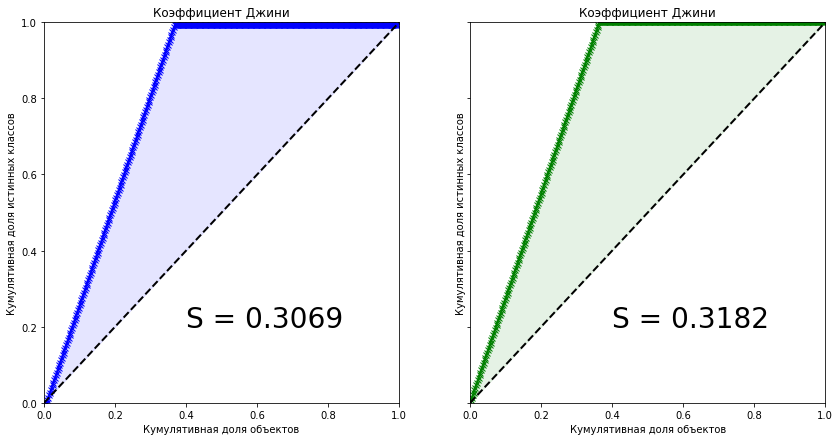

In [12]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = test.Survived
predict = better.predict_proba(np.array(test[features]))[:, 1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=len(x_values))[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=len(x_values))[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();